In [445]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
import networkx as nx
from exchange.ftx.client import FtxClient

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = FtxClient()


In [453]:
minimum_date = datetime.fromisoformat('2021-07-01 00:00:00+00:00')
maximum_date = datetime.fromisoformat('2021-09-01 00:00:00+00:00')
minimum_volume = 5000000
resolution = '15m'
futures = client.get_futures()
perps = []
for future in futures:
    if 'PERP' in future['name'] and future['volumeUsd24h'] > minimum_volume:
        perps.append(future['name'])

#perps = ['BTC-PERP', 'ETH-PERP', 'SOL-PERP', 'AVAX-PERP', 'MATIC-PERP', 'XRP-PERP', 'BNB-PERP', 'AAVE-PERP', 'ADA-PERP', 'LINK-PERP', 'DOT-PERP', 'FTT-PERP', 'DOGE-PERP', 'SAND-PERP', 'LTC-PERP', 'TRX-PERP', 'BCH-PERP', 'AXS-PERP', 'EOS-PERP', 'SNX-PERP', 'SUSHI-PERP', 'ETC-PERP', 'ALT-PERP', 'SHIT-PERP', 'DEFI-PERP', 'ZEC-PERP', 'XMR-PERP', 'PRIV-PERP']
#perps = ['ZEC-PERP', 'XMR-PERP']

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('/Users/walidmadaoui/Desktop/ARB/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

prices_df = pd.DataFrame(prices)[minimum_date:maximum_date].T.dropna().T

prices_df

Cannot find OP-PERP data


,1INCH-PERP,AAVE-PERP,ADA-PERP,ALGO-PERP,ALPHA-PERP,ALT-PERP,AR-PERP,ASD-PERP,ATOM-PERP,AUDIO-PERP,...,WAVES-PERP,XEM-PERP,XLM-PERP,XMR-PERP,XRP-PERP,XTZ-PERP,YFI-PERP,YFII-PERP,ZEC-PERP,ZIL-PERP
startTime,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00+00:00,2.4945,247.80,1.369315,0.8731,0.47050,3293.55,10.200,0.36528,11.8695,0.7740,...,16.0020,0.13195,0.277925,218.91,0.694750,3.0274,33600.0,1950.50,129.22,0.08626
2021-07-01 00:15:00+00:00,2.4969,247.73,1.370415,0.8720,0.47015,3295.95,10.236,0.36528,11.8140,0.7710,...,15.8915,0.13205,0.278275,218.92,0.693250,3.0183,33625.0,1946.75,128.81,0.08600
2021-07-01 00:30:00+00:00,2.4931,247.56,1.366110,0.8725,0.46915,3296.10,10.265,0.36528,11.7845,0.7725,...,15.8085,0.13380,0.278750,218.79,0.692350,3.0218,33655.0,1945.25,128.88,0.08604
2021-07-01 00:45:00+00:00,2.4837,248.33,1.366875,0.8695,0.46825,3292.20,10.242,0.36502,11.7100,0.7725,...,15.8280,0.13420,0.278725,218.26,0.691975,3.0187,33620.0,1949.00,128.79,0.08615
2021-07-01 01:00:00+00:00,2.4916,248.81,1.370215,0.8725,0.46995,3299.70,10.155,0.36526,11.7580,0.7730,...,15.8795,0.13525,0.280300,218.52,0.693975,3.0326,33760.0,1969.75,129.15,0.08631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 23:00:00+00:00,3.0628,394.41,2.777250,1.1030,1.22135,5388.75,64.471,0.41085,22.8170,2.4535,...,27.7095,0.19240,0.342950,286.85,1.176650,5.1405,38400.0,6400.00,143.89,0.10795
2021-08-31 23:15:00+00:00,3.0622,395.17,2.778055,1.1038,1.22075,5407.70,63.825,0.41038,23.2070,2.4610,...,27.9580,0.19240,0.343450,287.90,1.178900,5.1708,38430.0,6343.25,144.21,0.10831
2021-08-31 23:30:00+00:00,3.0577,395.47,2.781645,1.1093,1.22785,5428.55,64.042,0.41043,22.9885,2.4715,...,28.2300,0.19305,0.344200,288.02,1.193500,5.1845,38480.0,6276.00,144.26,0.10855


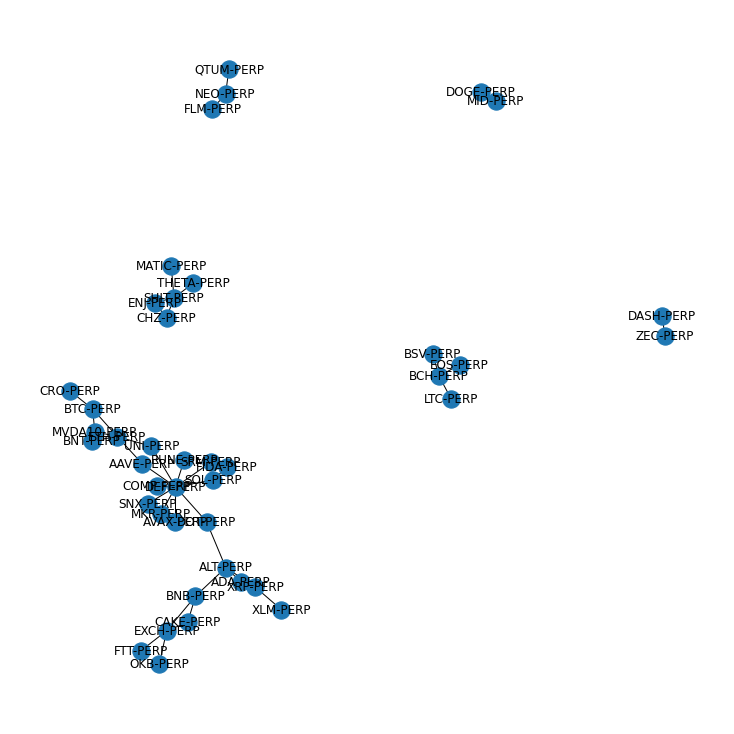

In [511]:
returns = prices_df.pct_change()[1:]
log_returns = np.log1p(returns)

edge_model = covariance.GraphicalLassoCV()
log_returns /= log_returns.std(axis=0)
#returns /= returns.std(axis=0)
edge_model.fit(log_returns)
#edge_model.fit(returns)
p = edge_model.precision_

#prepare the matrix for network illustration
p = pd.DataFrame(p, columns=prices_df.columns, index=prices_df.columns)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.1) &  (links['var1'] != links['var2']) ]
#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

In [455]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


In [537]:
# Find most mean reverting pairs
ridge = RidgeCV()
unique_pairs = []
possible_pairs = []
clusters = nx.connected_components(G)
for cluster in clusters:
    perps = list(cluster)
    for perp_a in perps:
        for perp_b in perps:
            pair = '{}/{}'.format(perp_a, perp_b)
            if perp_a != perp_b and '{}/{}'.format(perp_b, perp_a) not in unique_pairs:
                
                # regress prices
                ridge_reg = ridge.fit(prices_df[perp_a].values.reshape(-1, 1), prices_df[perp_b].values.reshape(-1, 1))

                # test for mean-reversion
                spread =  prices_df[perp_b] - ridge_reg.coef_[0][0] * prices_df[perp_a]
                half_life = calculat_half_life(spread)
                adf = adfuller(spread, 1)
                hurst = calculate_hurst(spread)

                # calculate positions ratio in dollars
                total_size = prices_df[perp_b] + ridge_reg.coef_[0][0] * prices_df[perp_a]
                size_ratio = prices_df[perp_b] / total_size

                possible_pairs.append({
                    'pair': pair,
                    'perp_a': perp_a,
                    'perp_b': perp_b,
                    'beta_units': ridge_reg.coef_[0][0],
                    'half_life': half_life,
                    'adf_pvalue': adf[1],
                    'hurst': hurst,
                    'long_short_position_ratio': size_ratio.mean()
                })

                unique_pairs.append(pair)

possible_pairs = pd.DataFrame(possible_pairs)
possible_pairs

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio
0,OKB-PERP/EXCH-PERP,OKB-PERP,EXCH-PERP,293.128699,1248.347458,0.711432,0.433516,0.632979
1,OKB-PERP/XRP-PERP,OKB-PERP,XRP-PERP,0.037292,1535.662213,0.769409,0.496080,0.572946
2,OKB-PERP/AVAX-PERP,OKB-PERP,AVAX-PERP,1.398963,3407.372643,0.878973,0.501883,0.433935
3,OKB-PERP/ADA-PERP,OKB-PERP,ADA-PERP,0.070687,-165154.218011,0.959666,0.510900,0.586593
4,OKB-PERP/COMP-PERP,OKB-PERP,COMP-PERP,5.032135,198.639012,0.009936,0.474854,0.837502
...,...,...,...,...,...,...,...,...
341,ZEC-PERP/DASH-PERP,ZEC-PERP,DASH-PERP,1.849666,332.114297,0.100536,0.457407,0.423676
342,MID-PERP/DOGE-PERP,MID-PERP,DOGE-PERP,0.000076,364.872904,0.117755,0.441080,0.495022
343,FLM-PERP/NEO-PERP,FLM-PERP,NEO-PERP,74.479885,213.422345,0.106772,0.433803,0.540528
344,FLM-PERP/QTUM-PERP,FLM-PERP,QTUM-PERP,22.147696,234.777513,0.091964,0.453903,0.451207


In [544]:
possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['hurst'])[:30]

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio
328,BCH-PERP/BSV-PERP,BCH-PERP,BSV-PERP,0.173845,61.376024,0.000021,0.312943,0.604469
330,BSV-PERP/LTC-PERP,BSV-PERP,LTC-PERP,1.435809,58.428339,0.000034,0.324660,0.415157
141,MVDA10-PERP/BNT-PERP,MVDA10-PERP,BNT-PERP,0.000122,90.665594,0.003036,0.340407,0.574267
252,BNT-PERP/ETH-PERP,BNT-PERP,ETH-PERP,962.318918,89.091608,0.002737,0.343964,0.428715
179,SOL-PERP/FIDA-PERP,SOL-PERP,FIDA-PERP,0.045106,92.259864,0.046187,0.347425,0.536345
210,SRM-PERP/FIDA-PERP,SRM-PERP,FIDA-PERP,0.528776,160.367272,0.132426,0.374839,0.487453
337,CHZ-PERP/ENJ-PERP,CHZ-PERP,ENJ-PERP,4.784287,203.476729,0.053772,0.377149,0.511854
36,EXCH-PERP/BNT-PERP,EXCH-PERP,BNT-PERP,0.000312,148.841561,0.011862,0.377694,0.583992
173,SOL-PERP/SRM-PERP,SOL-PERP,SRM-PERP,0.080841,246.847052,0.158958,0.390800,0.561954
326,EOS-PERP/BSV-PERP,EOS-PERP,BSV-PERP,21.607669,93.436175,0.001578,0.392574,0.609943


<AxesSubplot:title={'center':'ridge regression spread'}, xlabel='startTime'>

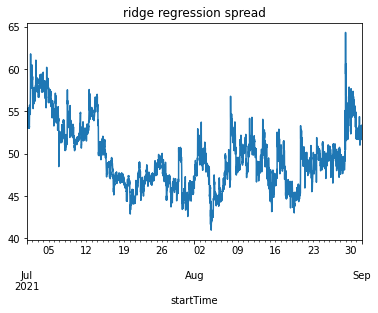

In [540]:
id = 328
sp2 = prices_df[possible_pairs.loc[id]['perp_b']] - possible_pairs.loc[id]['beta_units'] * prices_df[possible_pairs.loc[id]['perp_a']]
sp2.plot(title='ridge regression spread')
